In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, dataset
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
ionosphere = pd.read_csv("data/ionosphere/ionosphere.data", header=None)
y = ionosphere.pop(ionosphere.columns[-1])
X = ionosphere
y = y.map({'g': 1, 'b': 0}).astype(float)
assert X.shape[0] == len(y), f"Shape mismatch: X has {X.shape[0]} rows, but y has {len(y)} rows!"
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)

In [3]:
class CustomSGD:
    def __init__(self, params, pivot_lr=0.02, lr=0.01, lam=.9, patience=5, change_threshold=0.0001):
        self.params = list(params)
        self.lr = lr
        self.pivot_lr = pivot_lr
        self.lam = lam
        self.patience = patience
        self.change_threshold = change_threshold
        self.loss_history = []
        self.gradient_history = []

    def zero_grad(self) -> None:
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    def step(self, current_loss) -> None:
        self.loss_history.append(current_loss)
        gradient = []
        for p in self.params:
            gradient.append(p.grad.data)
        self.gradient_history.append(gradient)
        if len(self.loss_history) >= self.patience and (abs(sorted(self.loss_history)[-2] - min(self.loss_history)) < self.change_threshold < abs(max(self.loss_history) - min(self.loss_history))):
            grad = iter(self.gradient_history[0])
            for idx, (g, p) in enumerate(zip(grad, self.params)):
                g = self.mask_off(g.clone().detach(), gradient_history=self.gradient_history, idx= idx)
                p.data.add_(g, alpha=-self.pivot_lr)
            self.loss_history.pop(0)
        else:
            if len(self.loss_history) >= self.patience:
                self.loss_history.pop(0)
            for p in self.params:
                if p.grad is None:
                    continue
                else:
                    grad = p.grad.data
                    p.data.add_(grad, alpha=-self.lr)

    def mask_off(self, grad_copy, gradient_history=None, idx = None) -> torch.Tensor:
        grad = grad_copy
        grad = grad/torch.abs(torch.max(grad))
        original_shape = grad.shape
        grad_copy = grad.view(-1)
        final_grad = None
        grad_boolean_matrix = torch.zeros(original_shape).to(device)
        grad_boolean_matrix = grad_boolean_matrix.view(-1)
        for i in range(grad_copy.numel()):
            if torch.abs(grad_copy[i]) < self.lam: grad_boolean_matrix[i] = 1
        grad_boolean_matrix = grad_boolean_matrix.view(original_shape)
        if gradient_history is None and idx is None:
            final_grad = grad_boolean_matrix * grad_copy
        elif gradient_history is not None and idx is not None:
            tensors = [gradient_history[i][idx] for i in range(len(gradient_history))]
            summed = sum(tensor/torch.linalg.norm(tensor, ord=2) for tensor in tensors)
            final_grad = torch.zeros(original_shape).to(device) + summed * grad_boolean_matrix
        else:
            print(f'Error both gradient history and index must be passed')
        return final_grad

In [4]:
ionosphere_dataset = dataset.TensorDataset(X,y)
ionosphere_train = DataLoader(ionosphere_dataset, batch_size=32, shuffle=True)


class LinearModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        return self.sig(self.linear(x))

model = LinearModel(34).to(device)
criterion = nn.BCELoss()

In [5]:
torch_sgd = optim.SGD(model.parameters(), lr=.001)

epochs = 5
torch_losses = []

for epoch in range(epochs):
    for X_tensor, y_tensor in ionosphere_train:
        X_tensor = X_tensor.to(device)
        y_tensor = y_tensor.to(device)
        logits = model(X_tensor)
        loss = criterion(logits.view(-1), y_tensor)
        torch_losses.append(loss.item())
        torch_sgd.zero_grad()
        loss.backward()
        torch_sgd.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 1/5, Loss: 0.6942
Epoch 1/5, Loss: 0.7383
Epoch 1/5, Loss: 0.6983
Epoch 1/5, Loss: 0.6992
Epoch 1/5, Loss: 0.6995
Epoch 1/5, Loss: 0.7447
Epoch 1/5, Loss: 0.7234
Epoch 1/5, Loss: 0.6896
Epoch 1/5, Loss: 0.6841
Epoch 1/5, Loss: 0.6806
Epoch 1/5, Loss: 0.7064
Epoch 2/5, Loss: 0.7434
Epoch 2/5, Loss: 0.6789
Epoch 2/5, Loss: 0.6941
Epoch 2/5, Loss: 0.7032
Epoch 2/5, Loss: 0.6754
Epoch 2/5, Loss: 0.6758
Epoch 2/5, Loss: 0.7158
Epoch 2/5, Loss: 0.7199
Epoch 2/5, Loss: 0.6983
Epoch 2/5, Loss: 0.7264
Epoch 2/5, Loss: 0.6833
Epoch 3/5, Loss: 0.6991
Epoch 3/5, Loss: 0.6951
Epoch 3/5, Loss: 0.6503
Epoch 3/5, Loss: 0.6858
Epoch 3/5, Loss: 0.7181
Epoch 3/5, Loss: 0.7465
Epoch 3/5, Loss: 0.7085
Epoch 3/5, Loss: 0.6839
Epoch 3/5, Loss: 0.6727
Epoch 3/5, Loss: 0.7132
Epoch 3/5, Loss: 0.7002
Epoch 4/5, Loss: 0.6650
Epoch 4/5, Loss: 0.6788
Epoch 4/5, Loss: 0.6902
Epoch 4/5, Loss: 0.6954
Epoch 4/5, Loss: 0.6847
Epoch 4/5, Loss: 0.6983
Epoch 4/5, Loss: 0.6978
Epoch 4/5, Loss: 0.6676
Epoch 4/5, Loss:

In [6]:
model = LinearModel(34).to(device)

custom_sgd = CustomSGD(model.parameters(), lr=0.001, pivot_lr=0.02, lam=.9, patience=5, change_threshold=0.001)

custom_losses = []

for epoch in range(epochs):
    for X_tensor, y_tensor in ionosphere_train:
        X_tensor = X_tensor.to(device)
        y_tensor = y_tensor.to(device)
        logits = model(X_tensor)
        loss = criterion(logits.view(-1), y_tensor)
        custom_losses.append(loss.item())
        custom_sgd.zero_grad()
        loss.backward()
        custom_sgd.step(loss.item())
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')


Epoch 1/5, Loss: 0.7499
Epoch 1/5, Loss: 0.8125
Epoch 1/5, Loss: 0.7687
Epoch 1/5, Loss: 0.7269
Epoch 1/5, Loss: 0.7283
Epoch 1/5, Loss: 0.7106
Epoch 1/5, Loss: 0.7489
Epoch 1/5, Loss: 0.7405
Epoch 1/5, Loss: 0.7653
Epoch 1/5, Loss: 0.7815
Epoch 1/5, Loss: 0.7444
Epoch 2/5, Loss: 0.7272
Epoch 2/5, Loss: 0.7085
Epoch 2/5, Loss: 0.8132
Epoch 2/5, Loss: 0.7320
Epoch 2/5, Loss: 0.7770
Epoch 2/5, Loss: 0.7289
Epoch 2/5, Loss: 0.7048
Epoch 2/5, Loss: 0.7866
Epoch 2/5, Loss: 0.7634
Epoch 2/5, Loss: 0.7711
Epoch 2/5, Loss: 0.7246
Epoch 3/5, Loss: 0.8021
Epoch 3/5, Loss: 0.6776
Epoch 3/5, Loss: 0.7950
Epoch 3/5, Loss: 0.6968
Epoch 3/5, Loss: 0.7433
Epoch 3/5, Loss: 0.7349
Epoch 3/5, Loss: 0.7651
Epoch 3/5, Loss: 0.7256
Epoch 3/5, Loss: 0.6755
Epoch 3/5, Loss: 0.8081
Epoch 3/5, Loss: 0.7769
Epoch 4/5, Loss: 0.7179
Epoch 4/5, Loss: 0.7464
Epoch 4/5, Loss: 0.6988
Epoch 4/5, Loss: 0.7707
Epoch 4/5, Loss: 0.7982
Epoch 4/5, Loss: 0.7288
Epoch 4/5, Loss: 0.7200
Epoch 4/5, Loss: 0.7728
Epoch 4/5, Loss:

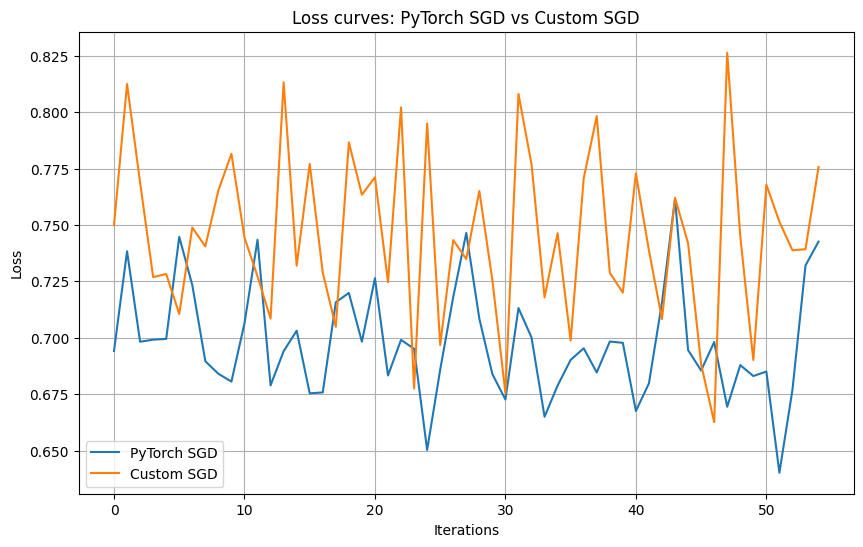

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(torch_losses, label='PyTorch SGD')
plt.plot(custom_losses, label='Custom SGD')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss curves: PyTorch SGD vs Custom SGD')
plt.legend()
plt.grid(True)
plt.show()